In [1]:
import numpy as np
import scipy.stats as stats             # For distribution functions
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d # For 3D graphs

plt.rcParams['axes.axisbelow'] = True   # Set axes and grid elements to be below the figure
# %matplotlib widget

## Fellers Square Root Process (Cox-Ingersoll-Ross Model)

![Feller Square-Root Process](square-root_mean-reverting_process.png)

In [2]:
N_SIMS = 20000                           # TODO: Number of simulations
N_STEPS = 200                            # TODO: Number of steps in each simulation
T = 1                                    # TODO: Time horizon
X0 = 0.03                                # TODO: Initial value of the process

THETA = 0.07                             # TODO: Mean reversion level (mu)
KAPPA = 5                                # TODO: Mean reversion rate (alpha)
SIGMA = 0.2                              # TODO: Volatility

dt = T / N_STEPS                         # Time step
t_steps = np.linspace(0, T, N_STEPS + 1) # Time points

# SIMULATION =======================================================================================
X = np.vstack([
    np.full(N_SIMS, X0),
    np.zeros((N_STEPS, N_SIMS))
])
Z = np.random.normal(size=(N_STEPS, N_SIMS))

# Euler-Maruyama method ----------------------------------------------------------------------------
# for i in range(N_STEPS):
#     X[i + 1] = X[i] + KAPPA * (THETA - X[i]) * dt + SIGMA * np.sqrt(X[i]) * np.sqrt(dt) * Z[i]
#     X[i + 1] = np.maximum(X[i + 1], 0)

# Gaussian Approximation ---------------------------------------------------------------------------
a = SIGMA**2 / KAPPA * (np.exp(-KAPPA * dt) - np.exp(-2 * KAPPA * dt))
b = THETA * SIGMA**2 / (2 * KAPPA) * (1 - np.exp(-KAPPA * dt))**2
for i in range(N_STEPS):
    X[i + 1] = THETA * (1 - np.exp(-KAPPA * dt)) + X[i] * np.exp(-KAPPA * dt) + np.sqrt(a * X[i] + b) * Z[i]
    X[i + 1] = np.maximum(X[i + 1], 0)

# Exact --------------------------------------------------------------------------------------------
# d = 4 * KAPPA * THETA / SIGMA**2
# k = SIGMA**2 * (1 - np.exp(-KAPPA * dt)) / (4 * KAPPA)
# for i in range(N_STEPS):
#     lam = 4 * KAPPA * X[i] / (SIGMA**2 * (np.exp(KAPPA * dt) - 1))
#     X[i + 1] = np.random.noncentral_chisquare(df = d, nonc = lam, size = (1, N_SIMS)) * k

# STATISTICS =======================================================================================
exact_mean = np.exp(-KAPPA * t_steps) * X0 + THETA * (1 - np.exp(-KAPPA * t_steps))
exact_var = X0 * SIGMA**2 / KAPPA * (np.exp(-KAPPA * t_steps) - np.exp(-2 * KAPPA * t_steps)) + THETA * SIGMA**2 / (2 * KAPPA) * (1 - np.exp(-KAPPA * t_steps))**2

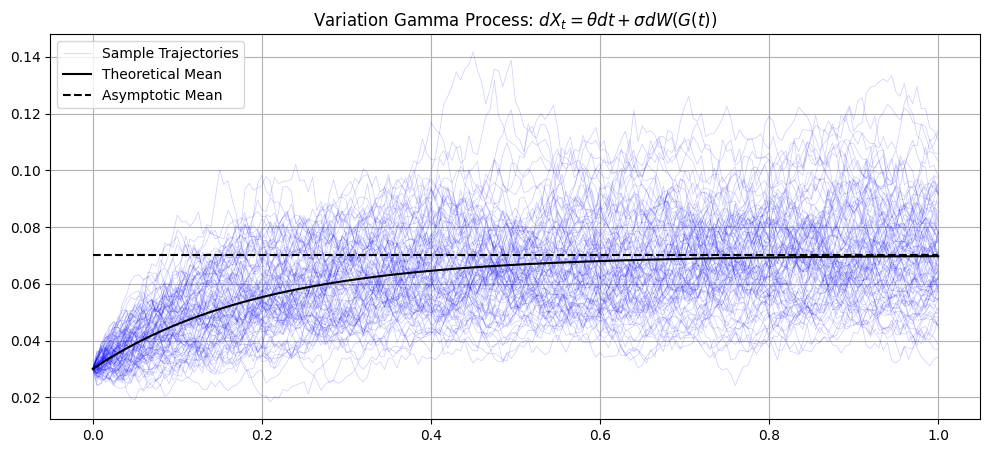

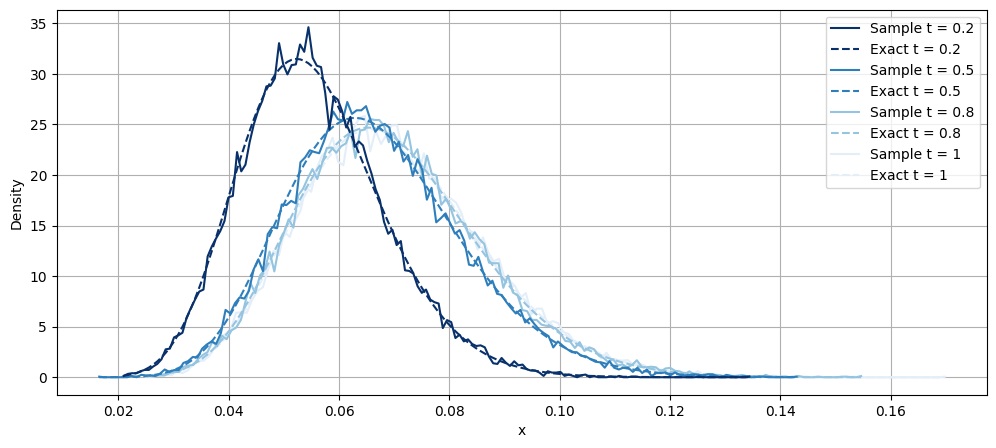

In [3]:
# Trajectories & Slices
# Price Trajectoris ==========================================================================
plt.figure(figsize = (12, 5), clear = True)

plt.title(r"Variation Gamma Process: $dX_t = \theta dt + \sigma dW(G(t))$")
plt.plot(t_steps, X[:,:100], color = "blue", alpha = 0.2, lw = 0.5, label = "Sample Trajectories")
plt.plot(t_steps, exact_mean, color = "black", ls = "-", label = "Theoretical Mean")
plt.plot(t_steps, np.full(N_STEPS + 1, THETA), color = "black", ls = "--", label = "Asymptotic Mean")

handles, labels = plt.gca().get_legend_handles_labels() # This gets the handles and labels of the current axes
by_label = dict(zip(labels, handles)) # dict(zip(keys, values)) is a way to create a dictionary from two lists
plt.legend(by_label.values(), by_label.keys())
plt.grid()
plt.show()

# Slices =====================================================================================
SLICES = [0.2, 0.5, 0.8, 1]       # FIXME: times to plot

plt.figure(figsize = (12, 5), clear = True)

colors = plt.cm.Blues(np.linspace(0.1, 1, len(SLICES))) # Inverse grey color direction

for i, time in enumerate(SLICES[::-1]): # Reverse slices so the nearest time is plotted at the front layer
    Xt = X[int(time * N_STEPS)]
    p, x = np.histogram(Xt, bins = 150, density = True)
    x = (x[:-1] + x[1:]) / 2 # Get the middle point of each bin

    # Compute theoretical density (non-central chi-squared distribution)
    d = 4 * KAPPA * THETA / SIGMA**2
    k = SIGMA**2 * (1 - np.exp(-KAPPA * time)) / (4 * KAPPA)
    lam = 4 * KAPPA * X0 / (SIGMA**2 * (np.exp(KAPPA * time) - 1))
    p_exact = stats.ncx2.pdf(x, df = d, nc = lam, scale = k)

    # Plot
    plt.plot(x, p_exact, color = colors[i], linestyle = "--", label = f"Exact t = {time}")
    plt.plot(x, p, color = colors[i], linestyle = "-", label = f"Sample t = {time}")

# Reverse legend order
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[::-1], labels[::-1])

plt.xlabel("x")
plt.ylabel("Density")
plt.grid()
plt.show()

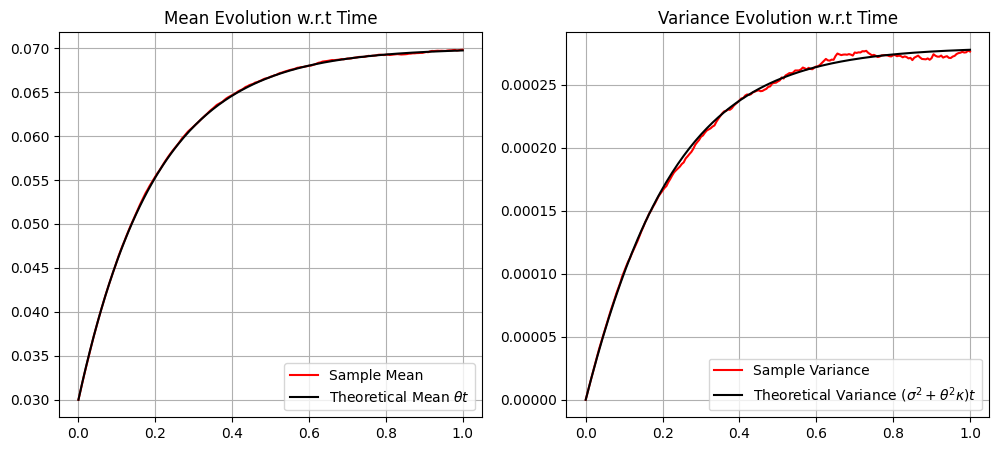

In [4]:
# Plotting Mean and Variance Convergence ==============================================
fig, ax = plt.subplots(1, 2, figsize = (12, 5), clear = True)

# Mean Convergence --------------------------------------------------------------------
ax[0].set_title("Mean Evolution w.r.t Time")
ax[0].plot(t_steps, X.mean(axis = 1), color = "red", label = "Sample Mean")
ax[0].plot(t_steps, exact_mean, color = "black", label = r"Theoretical Mean $\theta t$")

ax[0].grid()
ax[0].legend()

# Variance Convergence ----------------------------------------------------------------
ax[1].set_title("Variance Evolution w.r.t Time")
ax[1].plot(t_steps, X.var(axis = 1), color = "red", label = "Sample Variance")
ax[1].plot(t_steps, exact_var, color = "black", label = r"Theoretical Variance $(\sigma^2+\theta^2\kappa)t$")

ax[1].grid()
ax[1].legend()

plt.show()

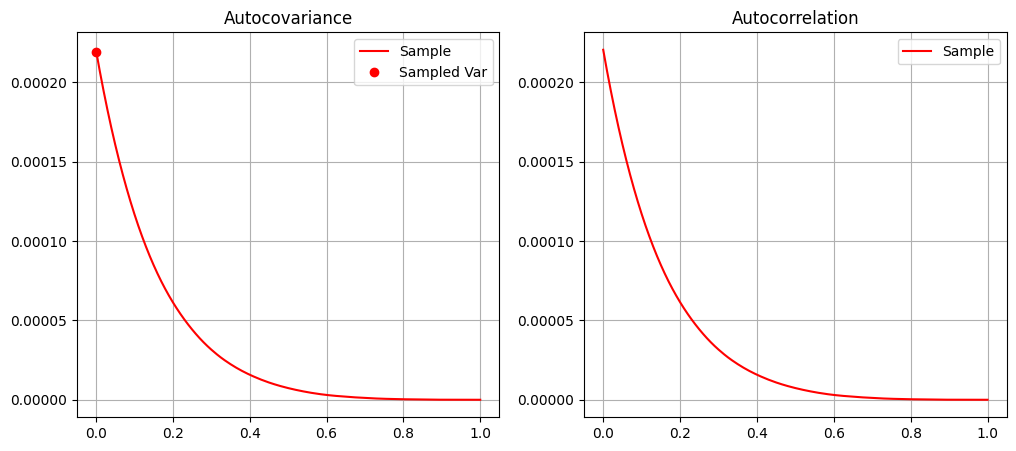

In [5]:
# Plotting Auto-covariance and Auto-correlation
# Compute autocovariance
sample_acov = np.zeros((N_STEPS * 2 + 1, N_SIMS))
for i in range(N_SIMS):
    sample_acov[:, i] = np.correlate(X[:, i] - exact_mean, X[:, i] - exact_mean, mode = "full") / N_STEPS
sample_acov = sample_acov[N_STEPS:].mean(axis = 1)
# exact_acov = 

# Compute autocorrelation
sample_acor = sample_acov / sample_acov[0]
# exact_acor = # UNKNOWN

# Plotting ============================================================================
fig, ax = plt.subplots(1, 2, figsize = (12, 5), clear = True)

# Auto-covariance ---------------------------------------------------------------------
ax[0].set_title("Autocovariance")
ax[0].plot(t_steps, sample_acov, color = "red", label = "Sample")
# ax[0].plot(t_steps, exact_acov, color = "black", label = "Theoretical")

# Plotting sample and theoretical variance
ax[0].plot(0, np.mean(np.var(X, axis=1)), 'o', color = "red", label = 'Sampled Var')

ax[0].legend()
ax[0].grid()

# Auto-correlation --------------------------------------------------------------------
ax[1].set_title("Autocorrelation")

ax[1].plot(t_steps, sample_acov, color = "red", label = "Sample")
# ax[1].plot(t_steps, exact_acov, color = "black", label = "Theoretical")

ax[1].grid()
ax[1].legend()

plt.show()

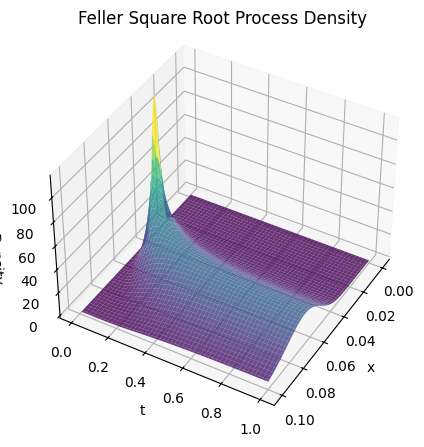

In [6]:
# 3D Plot --------------------------------------------------------------------

def fsr_density(x, t):
    k = SIGMA**2 * (1 - np.exp(-KAPPA * t)) / (4 * KAPPA)
    d = 4 * KAPPA * THETA / SIGMA**2
    l = 4 * KAPPA * X0 / (SIGMA**2 * (np.exp(KAPPA * t) - 1)) # Non-centrality parameter
    return stats.ncx2.pdf(x / k, df = d, nc = l) / k

# Create meshgrid
x_grid = np.linspace(0, 0.1, 100)
t_grid = np.linspace(0.01, 1, 100) # Avoid t = 0 for numerical stability
XV, TV = np.meshgrid(x_grid, t_grid)
ZV = fsr_density(XV, TV)

# Plot
fig = plt.figure(figsize = (12, 5), clear = True)
ax = fig.add_subplot(111, projection = '3d')

ax.set_title('Feller Square Root Process Density')
ax.plot_surface(XV, TV, ZV, cmap = plt.cm.viridis, alpha = 0.8)
ax.set_xlabel('x')
ax.set_ylabel('t')
ax.set_zlabel('Density')

# Angle
ax.view_init(40, 30)
plt.show()